In [43]:
#Importamos librerias utiles
import pandas as pd
import numpy as np
import math as m
import cv2
import sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


#leemos nuestros datos de Cuerpo
mediaCuerpo = pd.read_csv('mediaCuerpo.csv')
varianzaCuerpo = pd.read_csv('varianzaCuerpo.csv')
probCuerpo = pd.read_csv('probabilidadCuerpo.csv')

#leemos nuestros datos de Ojos
mediaOjos = pd.read_csv('mediaOjos.csv')
varianzaOjos = pd.read_csv('varianzaOjos.csv')
probOjos = pd.read_csv('probabilidadOjos.csv')

#leemos nuestros datos de Orejas
mediaOrejas = pd.read_csv('mediaOrejas.csv')
varianzaOrejas = pd.read_csv('varianzaOrejas.csv')
probOrejas = pd.read_csv('probabilidadOrejas.csv')

#mostrmos cualquier datafrme
probOrejas.info()
probOrejas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Probabilidad Orejas  5 non-null      float64
dtypes: float64(1)
memory usage: 168.0 bytes


,Probabilidad Orejas
0,0.027966
1,0.020744
2,0.031258
3,0.013943
4,0.018578


### Un poco de teoría

El clasificador naive Bayes es una forma de aprendizaje supervisado. El nombre de naive o ingenuo proviene de que este tipo de clasificadores se supone que cada par de caracteristicas es condicionalmente independiente entre sí.

Usando el teorema de Bayes es posible deducir que para cada clase $y$ y un vector de características $\vec{x} = x_1 , x_2 ,..., x_n$ tenemos que:

$$P(y| \vec{x}) \approx P(y)\prod_{i=1}^{n}P(x_i | y)$$
<br>
Donde asumimos que cada probabilidad $P(x_i | y)$ sigue una distribucion bien definida. $P(y)$ sera la probabilidad a priori.
De esta manera para cada columna de cada dataframe asumiremos que siguen una distribucion de probabilidad Gausiana o normal dada por:

$$P(x_i | y) = \frac{1}{\sqrt{2 \pi \sigma_{y}^{2}}} exp \left( - \frac{(x_y - \mu_y )^2}{2 \sigma_{y}^{2}}  \right)$$
<br>
El valor estimado $\hat{y}$ vendrá dado por:
<br>
$$\hat{y} = argmax_y P(y)\prod_{i=1}^{n}P(x_i | y)$$
<br>
Dado que asumimos que todas las clases (columnas de la tabla) siguen una distribución normal, debemos calcular $\sigma_{y}^{2}$ y $\mu_y$ para cada una de ellas, para posteriormente calcular $P(x_i | y)$ y finalmente obtener $P(y| \vec{x})$

### Inestabilidad númerica.
Hay ocasiones en las que python detecta algunos valores como si fueran cero. Sin embargo, dichos valores no son cero, son valores muy pequeños como $1\times10^{-2250}$. Esto se considera como una inestabilidad númerica.
<br>
Para evitar este problema calculamos la siguiente ecuacion:
<br>
$$ln(P(x_i | y)) = ln \left( \frac{1}{\sqrt{2 \pi \sigma_{y}^{2}}} exp \left( - \frac{(x_y - \mu_y )^2}{2 \sigma_{y}^{2}}  \right)\right)$$
<br>
donde $ln(x)$ es el logaritmo natural de x. Realizando algebra sencilla encontramos que la ecuacion anterior es:
$$ln(P(x_i | y)) = \left( \frac{-(\mu_y - x_y)^2}{2\sigma ^2} + ln\left( \frac{1}{\sigma}\right) - \frac{ln(2\pi)}{2} \right)$$
<br>
Por otro lado, veamos que:
<br>
$$ln(P(y| \vec{x})) \approx ln(P(y)\prod_{i=1}^{n}P(x_i | y))$$
<br>
Por propiedades de los logaritmos resulta ser:
<br>
$$ln(P(y| \vec{x})) \approx ln(P(y)) + \sum_{i=1}^{n}ln(P(x_i | y))$$
<br>

Dado que la predicción $\hat{y}$ escoge el valor maximo, aplicar el logaritmo natural a $P(y| \vec{x})$ no aporta información ya que el logaritmo es una función creciente en el intervalo $(0,\infty)$. Por lo que nuestra predicción $\hat{y}$ tambien será:
<br>
$$\hat{y} = argmax_y \left( ln(P(y)) + \sum_{i=1}^{n}ln(P(x_i | y))\right)$$
<br>

In [2]:
#Vamos a calcular la media de: las medias de cada color (BGR), las varianzas de cada color. Tambien,
#vamos a calculas la varianza de: las medias de cada color (BGR), las varianzas de cada color
#Para ello hacemos:
medCuerpo = mediaCuerpo.mean(axis=0)
medOjos = mediaOjos.mean(axis=0)
medOrejas = mediaOrejas.mean(axis=0)

#calculamos la varianza de cada columna para cada dataframe
varCuerpo = varianzaCuerpo.mean(axis=0)
varOjos = varianzaOjos.mean(axis=0)
varOrejas = varianzaOrejas.mean(axis=0)


#calculamos la varianza de cada columna para cada dataframe
#varCuerpo = varianzaCuerpo.var(axis=0)
#varOjos = varianzaOjos.var(axis=0)
#varOrejas = varianzaOrejas.var(axis=0)

#Convertimos el dataframe prob(Clase) a un array numpy
pCuerpo=probCuerpo.to_numpy()
pOjos = probOjos.to_numpy()
pOrejas = probOrejas.to_numpy()

varOjos

Varianza Azul Ojos     714.796175
Varianza Verde Ojos    656.297709
Varianza Rojo Ojos     914.892764
dtype: float64

In [3]:
#definimos la funcion logaritmo natural que come los parametros varianza, media y x
def log(x,med,var):
    ln = ((-1/(2*pow(var,2)))*(pow((med-x),2)))+(m.log((1/var)))-(m.log(2*m.pi)/2)
    return ln

In [55]:
#leemos la imagen de validacion puede ser test.png o test1.png
img = cv2.imread('test.png')
cv2.imshow('Imagen de Prueba',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
#vemos las probabilidades del cuerpo para cada imagen
pCuerpo

array([[0.36236191],
       [0.3694458 ],
       [0.34389496],
       [0.27164078],
       [0.33860397]])

In [56]:
#creamos los arrays auxiliares o imagenes resultado que nos van a servir para la clasificacion
Imagen = np.zeros(img.shape,dtype=float)
Imagen2 = np.zeros(img.shape,dtype=float)

In [34]:
#definimos las variables auxiliares para la clasificacion con y sin probabilidad a priori
PCe = 0
POe = 0
POre = 0

PCl = 0
POl = 0
POrl = 0

# Clasificacion
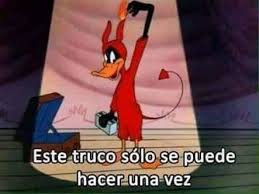

In [61]:
#clasificacion de la imagen 
#se recorre cada pixel de acuerdo a sus filas y columnas
for filas in range(img.shape[0]):
        for columnas in range(img.shape[1]):
            #sin a priori, aplicamos los logaritmos a x=img[filas][columnas] segun su color y su clase, media = media de las medias medClase[color] segun color
            #y varianza = varClase[color] segun su color el valor que retorna la funcion log lo guardamos en las variables PCe,POe y POre que son las 
            #probabilidades de atributo dada una clase. PCe Cuerpo, POe Ojos, POre orejas
            PCe = log(img[filas][columnas][0],medCuerpo[0],varCuerpo[0])+log(img[filas][columnas][1],medCuerpo[1],varCuerpo[1])+log(img[filas][columnas][2],medCuerpo[2],varCuerpo[2])
            POe = log(img[filas][columnas][0],medOjos[0],varOjos[0])+log(img[filas][columnas][1],medOjos[1],varOjos[1])+log(img[filas][columnas][2],medOjos[2],varOjos[2])
            POre = log(img[filas][columnas][0],medOrejas[0],varOrejas[0])+log(img[filas][columnas][1],medOrejas[1],varOrejas[1])+log(img[filas][columnas][2],medOrejas[2],varOrejas[2])
            #vemos que probabilidad fue maxima
            maximo=max(PCe,POe,POre)
            #si la probabilidad maxima fue la del cuerpo entonces escribimos en la imagen resultado Imagen la media de las medias de cada color del cuerpo
            if maximo == PCe:
                Imagen[filas][columnas][0] = medCuerpo[0]
                Imagen[filas][columnas][1] = medCuerpo[1]
                Imagen[filas][columnas][2] = medCuerpo[2]
            #si la probabilidad maxima fue la de los ojos entonces escribimos en la imagen resultado Imagen la media de las medias de cada color de los ojos
            elif maximo == POe:
                Imagen[filas][columnas][0] = medOjos[0]
                Imagen[filas][columnas][1] = medOjos[1]
                Imagen[filas][columnas][2] = medOjos[2]
            #si la probabilidad maxima fue la de las orejas entonces escribimos en la imagen resultado Imagen la media de las medias de cada color de las orejas
            elif maximo ==POre:
                Imagen[filas][columnas][0] = medOrejas[0]
                Imagen[filas][columnas][1] = medOrejas[1]
                Imagen[filas][columnas][2] = medOrejas[2]
                
            #con a priori, aplicamos los logaritmos a x=img[filas][columnas] segun su color y su clase, media = media de las medias medClase[color] segun color
            #y varianza = varClase[color] segun su color el valor que retorna la funcion log lo guardamos en las variables PCe,POe y POre que son las 
            #probabilidades de atributo dada una clase. PCl Cuerpo, POl Ojos, POrl orejas. Las constantes que se restan al final corresponden a
            #los valores de los logaritmos de las medias de las medias de la probabilidad de cada clase ln((mediaprob(Clase))), esto lo calcule en excel y lo puse
            #asi porque ya no me dio tiempo de hacerlo en python, que obviamente es sencillo pero debemmos considerar que uno se atora cuando no sabe bien que onda 
            PCl = log(img[filas][columnas][0],medCuerpo[0],varCuerpo[0])+log(img[filas][columnas][1],medCuerpo[1],varCuerpo[1])+log(img[filas][columnas][2],medCuerpo[2],varCuerpo[2])+(-1.0871103)
            POl = log(img[filas][columnas][0],medOjos[0],varOjos[0])+log(img[filas][columnas][1],medOjos[1],varOjos[1])+log(img[filas][columnas][2],medOjos[2],varOjos[2])+(-2.581123)
            POrl = log(img[filas][columnas][0],medOrejas[0],varOrejas[0])+log(img[filas][columnas][1],medOrejas[1],varOrejas[1])+log(img[filas][columnas][2],medOrejas[2],varOrejas[2])+(-3.7943484)
            #vemos que probabilidad fue maxima y la definimos como maximo1 para evitar sobreescribir la variable del maximo para el caso donde no se considera la apriori
            maximo1=max(PCl,POl,POrl)
            #si la probabilidad maxima fue la del cuerpo entonces escribimos en la imagen resultado Imagen2 la media de las medias de cada color del cuerpo
            if maximo1 == PCl:
                Imagen2[filas][columnas][0] = medCuerpo[0]
                Imagen2[filas][columnas][1] = medCuerpo[1]
                Imagen2[filas][columnas][2] = medCuerpo[2]
            #si la probabilidad maxima fue la de los ojos entonces escribimos en la imagen resultado Imagen2 la media de las medias de cada color de los ojos
            elif maximo1 == POl:
                Imagen2[filas][columnas][0] = medOjos[0]
                Imagen2[filas][columnas][1] = medOjos[1]
                Imagen2[filas][columnas][2] = medOjos[2]
            #si la probabilidad maxima fue la de las orejas entonces escribimos en la imagen resultado Imagen2 la media de las medias de cada color de las orejas
            elif maximo1 ==POrl:
                Imagen2[filas][columnas][0] = medOrejas[0]
                Imagen2[filas][columnas][1] = medOrejas[1]
                Imagen2[filas][columnas][2] = medOrejas[2]
            #si no podemos decidir entonces escribimos amarillo, esto se me olvido quitarlo. En las imagenes resultantes no se ve ningun amarillo por lo que este caso no se ejecuta
            else:
                Imagen[filas][columnas][0] = 0
                Imagen[filas][columnas][1] = 255
                Imagen[filas][columnas][2] = 255
            #reseteamos las variables auxiliares ya que si no se hace los calculos seran erroneos para el siguiente pixel    
            PCe =0
            POe=0
            POre=0
            maximo=0
            PCl =0
            POl=0
            POrl=0
            maximo1=0

In [62]:
#convertimos nustras imagenes resultado Imagen e Imagen2 a uint8, esto para que se pueda desplegar como imagen
#correctamente. j es la variable que tendra Imagen y j1 tendra Imagen2
j = Imagen.astype(np.uint8)
j2= Imagen2.astype(np.uint8)

In [64]:
#mostramos el resultado de Imagen y la guardamos
cv2.imshow('Imagen de Prueba',j)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite('SinaPriori.png', j)

True

In [65]:
#mostramos el resultado de Imagen2 y la guardamos
cv2.imshow('Imagen de Prueba',j2)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite('ConaPriori.png', j2)

True

# FIN